In [1]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import copy

In [2]:
client = MongoClient()
db = client.heroku_rnwkcq9r

In [41]:
def question_text(question_id):
    question = db.question.find_one({'_id': question_id})
    return question['text']

def question_max_value(question_id):
    question = db.question.find_one({'_id': question_id})
    if question['question_type'] == "boolean":
        return 1
    elif question["question_type"] == "numerical":
        if 'numericalAnswers' in question:
            max_value = max(map(int,question['numericalAnswers'].keys()))
            return max_value
        else:
            return 5

def answer_value(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer'] / float(question_max_value(q_id))
    elif 'boolean_answer' in answer:
        return answer['boolean_answer'] / float(question_max_value(q_id))

def answer_with_score(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    return 'text_answer' not in answer

def have_graded_handin(handin_id,grader_id):
    report_grade = db.report_grade.find({'handin': handin_id, 'giver': grader_id})
    if report_grade.count() != 0:
        return True
    return False

def score_handin_grader(handin_id,grader_id):
    # find all answers to the hand in of the grader and average it out
    report_grade = db.report_grade.find_one({'handin': handin_id, 'giver': grader_id})
    answers = db.answer.find({'report_grade': report_grade['_id'] })
    n_asnweres = 0
    handin_acc = 0.0
    for answer in answers:
        if answer_with_score(answer['_id']):
            handin_acc = handin_acc + answer_value(answer['_id'])
            n_asnweres = n_asnweres + 1
    return handin_acc / float(n_asnweres)

def score_handin_list(handin_id):
    scores = list()
    report_grades = db.report_grade.find({'handin': handin_id, 'state': 'ANSWERED'})
    for report_grade in report_grades:
        if report_grade['giver'] not in [ObjectId("56151d31ed0827000f7ad204"),ObjectId("56151d6bed0827000f7ad205")]:
            scores.append((score_handin_grader(handin_id,report_grade['giver']),report_grade['giver']))
    return scores

# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def assignment_handins(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append((score_handin_list(handin['_id']),handin['_id']))
    return handins_reports

# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def assignment_handins_id(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append(handin['_id'])
    return handins_reports

In [42]:
def handin_model(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        (scores,h_id) = data[h]
        N_G = len(scores)
        
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=T_tau)
        
        for g in range(0, N_G):
            (val,g_id) = scores[g]

            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
            O.append(pm.Normal('O_%(h)s_%(g)s' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [43]:
def execute_model(model,samples):
    mcmc = pm.MCMC(model)
    mcmc.sample(samples)
    return mcmc

In [44]:
def run_3_iteration(model_,values,samples):
    model_back = model_(values)
    mcmc_back_1 = execute_model(model_back,samples)
    mcmc_back_2 = execute_model(model_back,samples)
    mcmc_back_3 = execute_model(model_back,samples)
    return [mcmc_back_1,mcmc_back_2,mcmc_back_3]

### Assignment 1

In [200]:
data_assignment_1 = assignment_handins(ObjectId("5602625c568a61000f81eddd"))

In [201]:
mcmc = run_3_iteration(handin_model,data_assignment_1,1500)

 [-----------------100%-----------------] 1500 of 1500 complete in 41.5 sec

In [202]:
def student_id(user_id):
    student = db.user.find_one({'_id': user_id})
    if '@student.dtu.dk' in student['email']:
        return student['email'][:7]
    else:
        return student['email']
    
def get_TA_scores(assignment_id):
    TA1_Scores = dict()
    TA2_Scores = dict()
    Ass1B = defaultdict(list, json.load(open('SocialGraph/Ass1Bjarke.json')) )
    Ass1S = defaultdict(list, json.load(open('SocialGraph/Ass1Snorre.json')) )

    questions_norm = []
    for section_id in db.assignment.find_one({'_id': assignment_id})['sections']:
        for question_id in db.question_section.find_one({'_id': section_id})['questions']:
            q = db.question.find_one({'_id': question_id})
            if q['question_type'] == 'numerical' or q['question_type'] == 'boolean':
                norm = 3.0 if q['question_type'] == 'numerical' else 1.0
                questions_norm.append(norm)
                
    # Find the TA scores for the handins
    for handin in db.handin.find({'assignment': assignment_id}):
        studentId = student_id(handin['submitter'])
        # Hot fix
        handin_scores_ta1 = list()
        handin_scores_ta2 = list()
        for index, question_norm in enumerate(questions_norm):
            if studentId in Ass1B:
                handin_scores_ta1.append(Ass1B[studentId][index] / question_norm)
            if studentId in Ass1S:
                handin_scores_ta2.append(Ass1S[studentId][index] / question_norm)
        if len(handin_scores_ta1) != 0:
            TA1_Scores[str(handin['_id'])] = np.mean(handin_scores_ta1)
        if len(handin_scores_ta2) != 0:
            TA2_Scores[str(handin['_id'])] = np.mean(handin_scores_ta2)
    return TA1_Scores, TA2_Scores

In [219]:
def plot_result_ass1(_id,data,mcmc,find,func=np.mean):
    data_1 = find(_id, mcmc[0], func)
    data_2 = find(_id, mcmc[1], func)
    data_3 = find(_id, mcmc[2], func)
    

    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = data_1[:]
    collected.extend(data_2[:])
    collected.extend(data_3[:])
    for (value, g_id) in collected:
        compared[g_id].append(value)
    # Produce a box plot where the graders are sorted after mean value of the found values
    ax = plt.subplot(111)

    sorted_list = compared.items()
    sorted_list.sort(key=lambda x: np.mean(x[1][:]))

    labels = list()
    if 'bias' in find.func_name:
        for (g_id, value) in sorted_list:
            name = grader_name(ObjectId(g_id))
            reported = number_of_reports(ObjectId(g_id), _id)
            labels.append(name + ": " + str(reported))
        values = map(lambda x: x[1], sorted_list)
        plt.boxplot(values,0, vert=False, labels=labels)
        plt.vlines(0, 0, 120, color="k", linestyles="--", lw=1)
    else:
        model_points = list()
        ta1_points = list()
        ta1_points_y = list()
        ta2_points = list()
        ta2_points_y = list()
        bp_points = list()
        
        for i, (h_id, value) in enumerate(sorted_list):
            labels.append(h_id)
            model_points.append(func(value))
            TA1_scores, TA2_scores = get_TA_scores(_id)
            if h_id in TA1_scores: 
                ta1_points.append(TA1_scores[h_id])
                ta1_points_y.append(i)

            if h_id in TA2_scores: 
                ta2_points.append(TA2_scores[h_id])
                ta2_points_y.append(i)
            scores = list()
            for (score,_) in score_handin_list(ObjectId(h_id)):
                scores.append(score)
            bp_points.append(scores)

        _i = range(len(sorted_list))
        plt.plot(model_points,_i,'or',alpha = 0.7, label="Model")
        plt.plot(ta1_points,ta1_points_y,'ob',alpha = 0.7, label="TA1")
        plt.plot(ta2_points,ta2_points_y,'og',alpha = 0.7, label="TA2")
        plt.boxplot(bp_points, positions=_i, vert=False)

        plt.yticks(range(len(sorted_list)), labels)
        plt.xlim(0,1)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("gradings")
        plt.ylabel("handins")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width*1.5, box.height*5])

    plt.show()

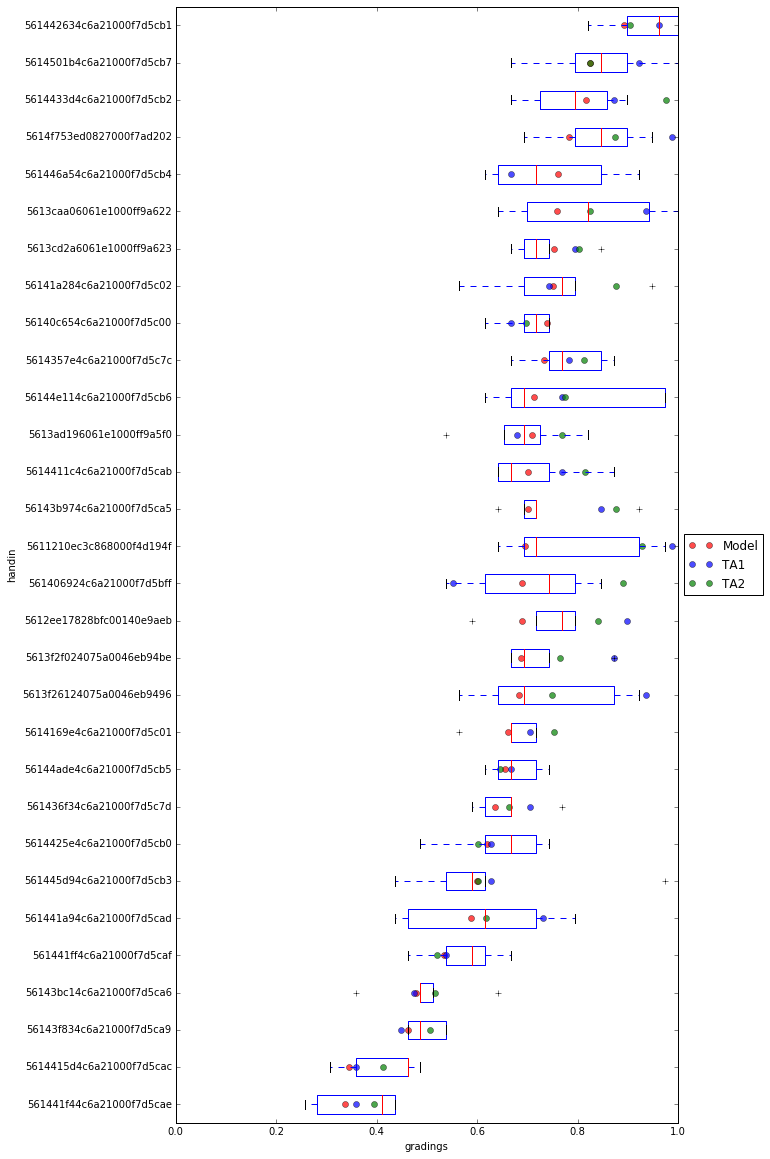

In [220]:
plot_result_ass1(ObjectId("5602625c568a61000f81eddd"),data_assignment_1,mcmc,find_T)

### Assignment 2

In [156]:
data_assignment_2 = assignment_handins(ObjectId("562d0edb79c852000f99c6dd"))

In [157]:
mcmc = run_3_iteration(handin_model,data_assignment_2,1500)

 [-----------------100%-----------------] 1501 of 1500 complete in 51.5 sec

In [158]:
def grader_ids(assignment_id):
    graders = set()
    report_grades = db.report_grade.find({'assignment':assignment_id})
    for report_grade in report_grades:
        graders.add(report_grade['giver'])
    return list(graders)

def grader_ids_course(course_id):
    graders = set()
    course = db.course.find_one({'_id':course_id})
    return course['students']

def grader_id(grader_name):
    grader = db.user.find_one({'name': grader_name})
    return grader['_id']

def grader_name(grader_id):
    grader = db.user.find_one({'_id': grader_id})
    return grader['name']

def find_bias(assignment_id,mcmc,f):
    bias_abs = list()
    for g in grader_ids(assignment_id):
        try:     
            bias_mean = f(mcmc.trace('B_%s' % str(g))[:])
            name = str(g)
            bias_abs.append((bias_mean,name))
        except:
#            print "error for grader: %s" % grader_name(g)
            pass
    return bias_abs

def find_T(assignment_id,mcmc,f):
    bias = list()
    for h in assignment_handins_id(assignment_id):
        try:     
            bias_mean = f(mcmc.trace('T_%s' % str(h))[:])
            name = str(h)
            bias.append((bias_mean,name))
        except:
            #print "error for grader: %s" % grader_name(g)
            pass
    return bias

def number_of_reports(g_id, assignment_id):
    reports = db.report_grade.find({'assignment': assignment_id, 'giver': g_id, 'state': 'ANSWERED'})
    return reports.count()

def number_of_reports_course(g_id, course_id):
    count = 0
    assignments = db.assignment.find({'course': course_id})
    for assignment in assignments:
        reports = db.report_grade.find({'assignment': assignment['_id'], 'giver': g_id, 'state': 'ANSWERED'})
        count = count + reports.count()
    return count

In [230]:
def plot_result(_id,data,mcmc,find,func=np.mean):
    data_1 = find(_id, mcmc[0], func)
    data_2 = find(_id, mcmc[1], func)
    data_3 = find(_id, mcmc[2], func)
    

    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = data_1[:]
    collected.extend(data_2[:])
    collected.extend(data_3[:])
    for (value, g_id) in collected:
        compared[g_id].append(value)
        
    # Produce a box plot where the graders are sorted after mean value of the found values
    ax = plt.subplot(111)

    sorted_list = compared.items()
    sorted_list.sort(key=lambda x: np.mean(x[1][:]))

    labels = list()
    if 'bias' in find.func_name:
        for (g_id, value) in sorted_list:
            name = grader_name(ObjectId(g_id))
            reported = number_of_reports(ObjectId(g_id), _id)
            labels.append(name + ": " + str(reported))
        values = map(lambda x: x[1], sorted_list)
        plt.boxplot(values,0, vert=False, labels=labels)
        plt.vlines(0, 0, 120, color="k", linestyles="--", lw=1)
    else:
        model_points = list()
        ta1_points = list()
        ta1_points_y = list()
        ta2_points = list()
        ta2_points_y = list()
        bp_points = list()
        for i, (h_id, value) in enumerate(sorted_list):
            labels.append(h_id)
            model_points.append(func(value))
            TA1_scores, TA2_scores = get_TA_scores(_id)
            if have_graded_handin(ObjectId(h_id),ObjectId("56151d6bed0827000f7ad205")):
                ta1_points.append(score_handin_grader(ObjectId(h_id),ObjectId("56151d6bed0827000f7ad205")))
                ta1_points_y.append(i)
            if have_graded_handin(ObjectId(h_id),ObjectId("56151d31ed0827000f7ad204")):
                ta1_points.append(score_handin_grader(ObjectId(h_id),ObjectId("56151d31ed0827000f7ad204")))
                ta1_points_y.append(i)
            scores = list()
            print "test"
            for (score,_) in score_handin_list(ObjectId(h_id)):
                scores.append(score)
            bp_points.append(scores)

        _i = range(len(sorted_list))
        plt.plot(model_points,_i,'or',alpha = 0.7, label="Model")
        plt.plot(ta1_points,ta1_points_y,'ob',alpha = 0.7, label="TA1")
        plt.plot(ta2_points,ta2_points_y,'og',alpha = 0.7, label="TA2")
        print len(bp_points)
        plt.boxplot(bp_points, positions=_i, vert=False)

        plt.yticks(range(len(sorted_list)), labels)
        plt.xlim(0,1)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("gradings")
        plt.ylabel("handin")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width*1.5, box.height*5])

#    plt.xlabel("Absolute mean value of the bias distributions of a grader")
    plt.show()

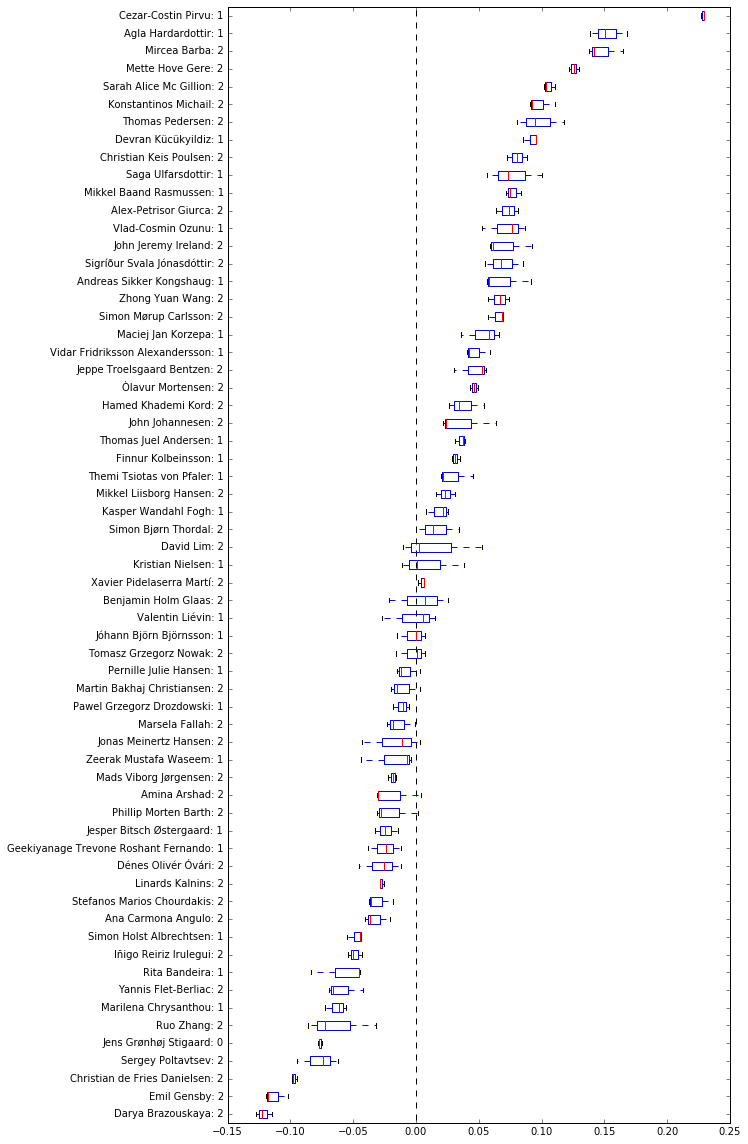

In [226]:
plot_result(ObjectId("562d0edb79c852000f99c6dd"),data_assignment_2,mcmc,find_bias)

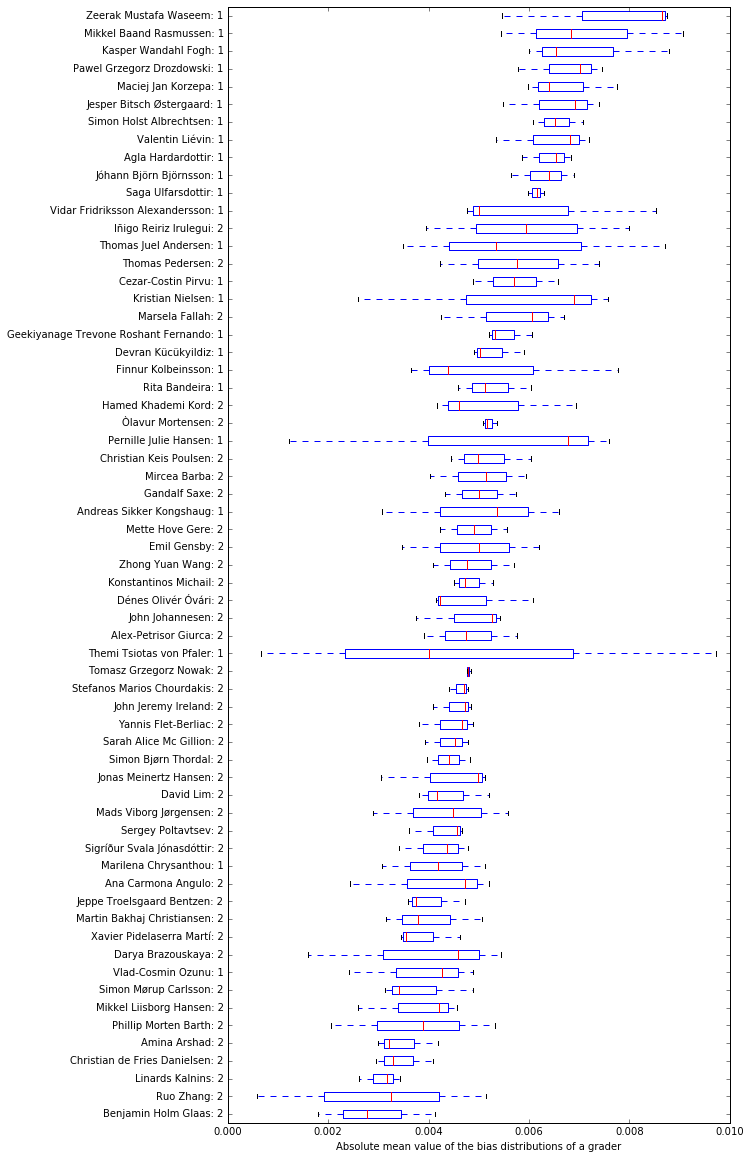

In [161]:
plot_result(ObjectId("562d0edb79c852000f99c6dd"),data_assignment_2,mcmc,find_bias,np.var)

0


IndexError: list index out of range

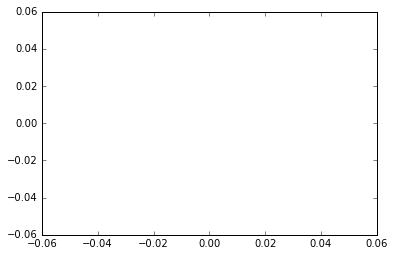

In [231]:
plot_result(ObjectId("562d0edb79c852000f99c6dd"),data_assignment_2,mcmc,find_T)

### All assignments

In [165]:
def course_handins(course_id):
    handins = list()
    assignments = db.assignment.find({'course':course_id})
    for assignment in assignments:
        handins.extend(assignment_handins(assignment['_id']))
    return handins

In [166]:
# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def course_handins_id(course_id):
    handins_reports = list()
    assignments = db.assignment.find({'course': course_id})
    for assignment in assignments:
        handins = db.handin.find({'assignment': assignment['_id']})
        for handin in handins:
            handins_reports.append(handin['_id'])
    return handins_reports

In [167]:
data_course = course_handins(ObjectId("55ffbaf722913c000f1bf8fd"))

In [168]:
mcmc_c = run_3_iteration(handin_model,data_course,1500)

 [-----------------100%-----------------] 1500 of 1500 complete in 113.4 sec

#### Assignment 1 Modeled on all data with TAs

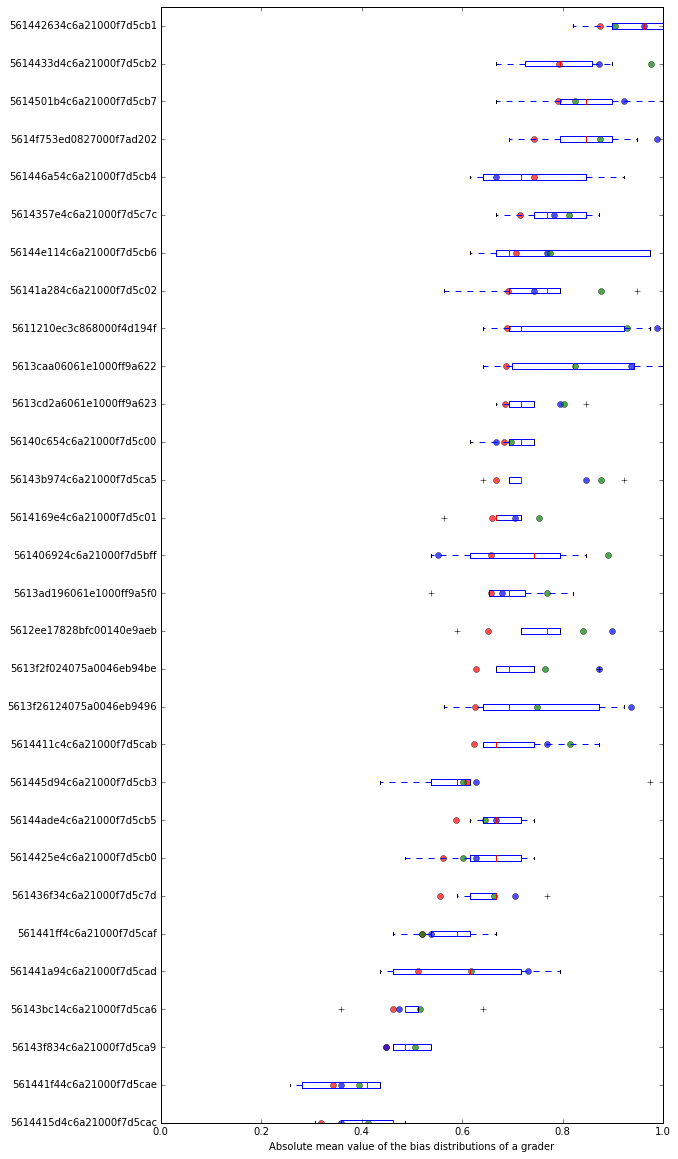

In [175]:
plot_result_ass1(ObjectId("5602625c568a61000f81eddd"),data_course,mcmc_c,find_T)

#### Assignment 2 modeled on all data with TAs

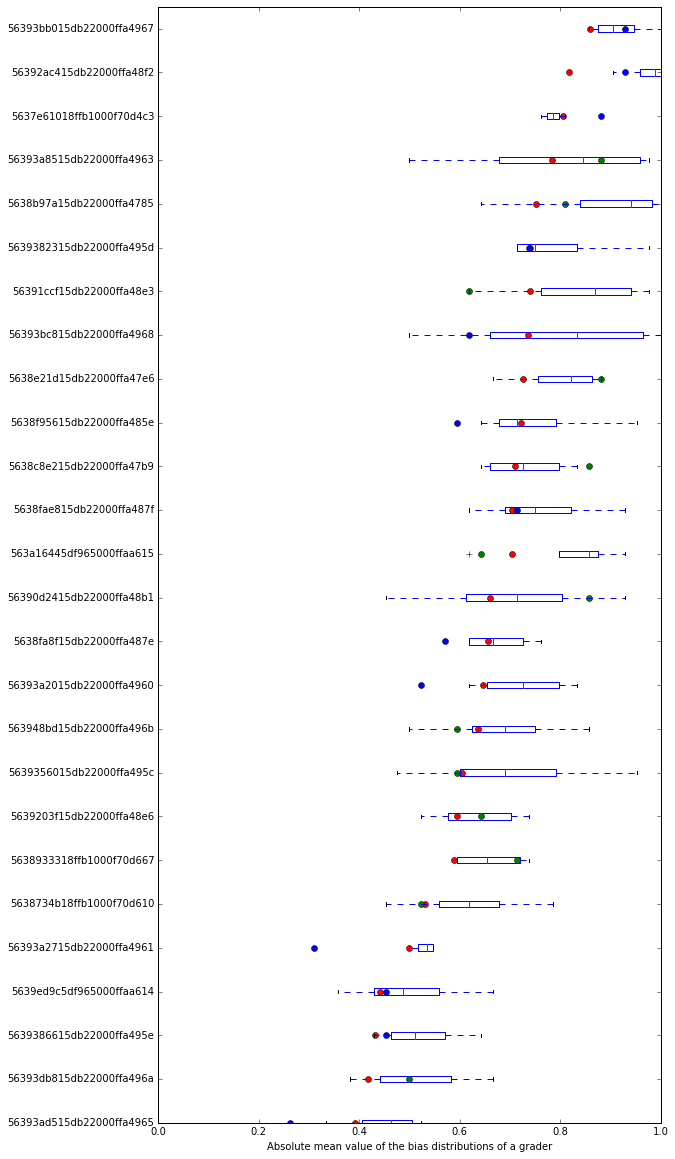

In [176]:
plot_result(ObjectId("562d0edb79c852000f99c6dd"),data_course,mcmc_c,find_T)